In [1]:
! pip install keras

In [2]:
! pip install tensorflow

# Load python packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions as fun
import deep_learning_helper as dp
import keras
import tensorflow as tf
import sklearn

%load_ext autoreload 
%autoreload 2

from keras import models
from tensorflow.keras import layers

# Load the data 

In [2]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

epoch_utc  emission_factor                datetime_de  windon_forecast  \
0  1.546297e+09       298.240217  2018-12-31 23:00:00+00:00         18879.75   
1  1.546301e+09       266.522473  2019-01-01 00:00:00+00:00         20626.50   
2  1.546304e+09       262.594215  2019-01-01 01:00:00+00:00         22355.50   
3  1.546308e+09       260.190772  2019-01-01 02:00:00+00:00         24032.50   
4  1.546312e+09       250.496683  2019-01-01 03:00:00+00:00         25452.00   

   windoff_forecast  solar_forecast  prices_forecast  \
0           5069.00             0.0            28.32   
1           5042.25             0.0            10.07   
2           5028.50             0.0            -4.08   
3           4977.75             0.0            -9.91   
4           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  ...  DK_import  \
0                         57054.0       61.0     4940.0  ...      901.0   
1                         57400.0       60.0     5073.0  ...      316.0   
2                         57275.0       20.0     4284.0  ...        0.0   
3                         58024.0        3.0     4273.0  ...        0.0   
4                         59301.0        0.0     4961.0  ...        0.0   

   DK_export  LU_import  LU_export  NL_import  NL_export  PL_import  \
0        0.0       12.0      418.0        0.0     1354.0      224.0   
1        0.0       16.0      398.0        0.0     1158.0        0.0   
2      405.0       19.0      379.0        0.0     1176.0        0.0   
3      619.0       23.0      373.0        0.0     1428.0        0.0   
4      689.0       27.0      370.0        0.0     1492.0        0.0   

   PL_export  CH_import  CH_export  
0        0.0        0.0      800.0  
1        0.0        1.0      801.0  
2        0.0        0.0      800.0  
3        0.0        0.0      800.0  
4        0.0        0.0      800.0  

[5 rows x 22 columns]

In [3]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [4]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [5]:
# check features
features.head()

epoch_utc                datetime_de  windon_forecast  windoff_forecast  \
0  1.546297e+09  2018-12-31 23:00:00+00:00         18879.75           5069.00   
1  1.546301e+09  2019-01-01 00:00:00+00:00         20626.50           5042.25   
2  1.546304e+09  2019-01-01 01:00:00+00:00         22355.50           5028.50   
3  1.546308e+09  2019-01-01 02:00:00+00:00         24032.50           4977.75   
4  1.546312e+09  2019-01-01 03:00:00+00:00         25452.00           4907.25   

   solar_forecast  prices_forecast  aggregated_generation_forecast  AT_import  \
0             0.0            28.32                         57054.0       61.0   
1             0.0            10.07                         57400.0       60.0   
2             0.0            -4.08                         57275.0       20.0   
3             0.0            -9.91                         58024.0        3.0   
4             0.0            -7.41                         59301.0        0.0   

   AT_export  CZ_import  ...  DK_import  DK_export  LU_import  LU_export  \
0     4940.0     1076.0  ...      901.0        0.0       12.0      418.0   
1     5073.0      514.0  ...      316.0        0.0       16.0      398.0   
2     4284.0        0.0  ...        0.0      405.0       19.0      379.0   
3     4273.0      111.0  ...        0.0      619.0       23.0      373.0   
4     4961.0        0.0  ...        0.0      689.0       27.0      370.0   

   NL_import  NL_export  PL_import  PL_export  CH_import  CH_export  
0        0.0     1354.0      224.0        0.0        0.0      800.0  
1        0.0     1158.0        0.0        0.0        1.0      801.0  
2        0.0     1176.0        0.0        0.0        0.0      800.0  
3        0.0     1428.0        0.0        0.0        0.0      800.0  
4        0.0     1492.0        0.0        0.0        0.0      800.0  

[5 rows x 21 columns]

## Feature Enginnering

### Create lagged features

In [6]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 26)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

y_lag_1     y_lag_2     y_lag_3     y_lag_4  y_lag_5  y_lag_6  y_lag_7  \
0    0.000000    0.000000    0.000000    0.000000      0.0      0.0      0.0   
1  298.240217    0.000000    0.000000    0.000000      0.0      0.0      0.0   
2  266.522473  298.240217    0.000000    0.000000      0.0      0.0      0.0   
3  262.594215  266.522473  298.240217    0.000000      0.0      0.0      0.0   
4  260.190772  262.594215  266.522473  298.240217      0.0      0.0      0.0   

   y_lag_8  y_lag_9  y_lag_10  ...  y_lag_17  y_lag_18  y_lag_19  y_lag_20  \
0      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
1      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
2      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
3      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   
4      0.0      0.0       0.0  ...       0.0       0.0       0.0       0.0   

   y_lag_21  y_lag_22  y_lag_23  y_lag_24  y_lag_25  y_lag_26  
0       0.0       0.0       0.0       0.0       0.0       0.0  
1       0.0       0.0       0.0       0.0       0.0       0.0  
2       0.0       0.0       0.0       0.0       0.0       0.0  
3       0.0       0.0       0.0       0.0       0.0       0.0  
4       0.0       0.0       0.0       0.0       0.0       0.0  

[5 rows x 26 columns]

In [7]:
# add lag 24 and 26 to the features

features[['co2_24_lag','co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

epoch_utc                datetime_de  windon_forecast  windoff_forecast  \
0  1.546297e+09  2018-12-31 23:00:00+00:00         18879.75           5069.00   
1  1.546301e+09  2019-01-01 00:00:00+00:00         20626.50           5042.25   
2  1.546304e+09  2019-01-01 01:00:00+00:00         22355.50           5028.50   
3  1.546308e+09  2019-01-01 02:00:00+00:00         24032.50           4977.75   
4  1.546312e+09  2019-01-01 03:00:00+00:00         25452.00           4907.25   

   solar_forecast  prices_forecast  aggregated_generation_forecast  AT_import  \
0             0.0            28.32                         57054.0       61.0   
1             0.0            10.07                         57400.0       60.0   
2             0.0            -4.08                         57275.0       20.0   
3             0.0            -9.91                         58024.0        3.0   
4             0.0            -7.41                         59301.0        0.0   

   AT_export  CZ_import  ...  LU_import  LU_export  NL_import  NL_export  \
0     4940.0     1076.0  ...       12.0      418.0        0.0     1354.0   
1     5073.0      514.0  ...       16.0      398.0        0.0     1158.0   
2     4284.0        0.0  ...       19.0      379.0        0.0     1176.0   
3     4273.0      111.0  ...       23.0      373.0        0.0     1428.0   
4     4961.0        0.0  ...       27.0      370.0        0.0     1492.0   

   PL_import  PL_export  CH_import  CH_export  co2_24_lag  co2_26_lag  
0      224.0        0.0        0.0      800.0         0.0         0.0  
1        0.0        0.0        1.0      801.0         0.0         0.0  
2        0.0        0.0        0.0      800.0         0.0         0.0  
3        0.0        0.0        0.0      800.0         0.0         0.0  
4        0.0        0.0        0.0      800.0         0.0         0.0  

[5 rows x 23 columns]

### Create temproal features

In [8]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [9]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  NL_export  PL_import  PL_export  CH_import  CH_export  \
0      901.0  ...     1354.0      224.0        0.0        0.0      800.0   
1      316.0  ...     1158.0        0.0        0.0        1.0      801.0   
2        0.0  ...     1176.0        0.0        0.0        0.0      800.0   
3        0.0  ...     1428.0        0.0        0.0        0.0      800.0   
4        0.0  ...     1492.0        0.0        0.0        0.0      800.0   

   co2_24_lag  co2_26_lag  hour_of_day  day_of_week  hour_of_year  
0         0.0         0.0           23            0          8759  
1         0.0         0.0            0            1             0  
2         0.0         0.0            1            1             1  
3         0.0         0.0            2            1             2  
4         0.0         0.0            3            1             3  

[5 rows x 24 columns]

In [10]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  co2_26_lag  hour_of_day  hour_of_year  day_of_week_fri  \
0      901.0  ...         0.0           23          8759                0   
1      316.0  ...         0.0            0             0                0   
2        0.0  ...         0.0            1             1                0   
3        0.0  ...         0.0            2             2                0   
4        0.0  ...         0.0            3             3                0   

   day_of_week_mon  day_of_week_sat  day_of_week_sun  day_of_week_thu  \
0                1                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   day_of_week_tue  day_of_week_wed  
0                0                0  
1                1                0  
2                1                0  
3                1                0  
4                1                0  

[5 rows x 30 columns]

In [11]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

windon_forecast  windoff_forecast  solar_forecast  prices_forecast  \
0         18879.75           5069.00             0.0            28.32   
1         20626.50           5042.25             0.0            10.07   
2         22355.50           5028.50             0.0            -4.08   
3         24032.50           4977.75             0.0            -9.91   
4         25452.00           4907.25             0.0            -7.41   

   aggregated_generation_forecast  AT_import  AT_export  CZ_import  CZ_export  \
0                         57054.0       61.0     4940.0     1076.0      569.0   
1                         57400.0       60.0     5073.0      514.0      694.0   
2                         57275.0       20.0     4284.0        0.0      685.0   
3                         58024.0        3.0     4273.0      111.0     1186.0   
4                         59301.0        0.0     4961.0        0.0     1122.0   

   DK_import  ...  day_of_week_mon  day_of_week_sat  day_of_week_sun  \
0      901.0  ...                1                0                0   
1      316.0  ...                0                0                0   
2        0.0  ...                0                0                0   
3        0.0  ...                0                0                0   
4        0.0  ...                0                0                0   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  hour_of_day_sin  \
0                0                0                0        -0.258819   
1                0                1                0         0.000000   
2                0                1                0         0.258819   
3                0                1                0         0.500000   
4                0                1                0         0.707107   

   hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
0         0.965926         -0.000717          1.000000  
1         1.000000          0.000000          1.000000  
2         0.965926          0.000717          1.000000  
3         0.866025          0.001435          0.999999  
4         0.707107          0.002152          0.999998  

[5 rows x 32 columns]

## Creation of LSTM

### Train Test Split

In [12]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)+1]
co2_train_val = co2[0:int(n*val_ratio)]
co2_val = co2[int(n*train_ratio)+1:int(n*val_ratio)+1]
co2_test = co2[int(n*val_ratio)+1:n-23]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)+1]
features_train_val = features[0:int(n*val_ratio)]
features_val = features[int(n*train_ratio)+1:int(n*val_ratio)+1]
features_test = features[int(n*val_ratio)+1:n-23]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [13]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


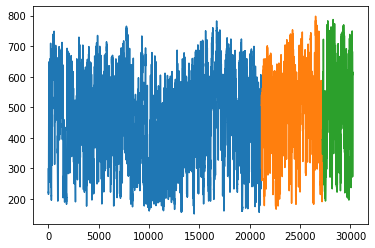

In [14]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

### Create walk forward split

In [15]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


In [16]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [17]:
for train_index, test_index in tscv_val.split(co2_train_val):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

TRAIN: [    0     1     2 ... 21164 21165 21166] TEST: [21167 21168 21169 21170 21171 21172 21173 21174 21175 21176 21177 21178
 21179 21180 21181 21182 21183 21184 21185 21186 21187 21188 21189 21190
 21191 21192 21193 21194 21195 21196 21197 21198 21199 21200 21201 21202
 21203 21204 21205 21206 21207 21208 21209 21210 21211 21212 21213 21214
 21215 21216 21217 21218 21219 21220 21221 21222 21223 21224 21225 21226
 21227 21228 21229 21230 21231 21232 21233 21234 21235 21236 21237 21238
 21239 21240 21241 21242 21243 21244 21245 21246 21247 21248 21249 21250
 21251 21252 21253 21254 21255 21256 21257 21258 21259 21260 21261 21262
 21263 21264 21265 21266 21267 21268 21269 21270 21271 21272 21273 21274
 21275 21276 21277 21278 21279 21280 21281 21282 21283 21284 21285 21286
 21287 21288 21289 21290 21291 21292 21293 21294 21295 21296 21297 21298
 21299 21300 21301 21302 21303 21304 21305 21306 21307 21308 21309 21310
 21311 21312 21313 21314 21315 21316 21317 21318 21319 21320 21321 21

In [18]:
co2_train_val.shape, co2_test.shape, co2.shape, co2_val.shape

((27215,), (3000,), (30239,), (6048,))

In [19]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 125)

In [20]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

# Define the Neural Network

In [21]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout, Flatten
from keras.layers import LeakyReLU
import keras.backend as K
from keras.layers import LSTM
#### Todos:
# add probabiltic prediction
# LSTM dropout
# kernel regulizer
# second lstm
# recurrend regulizer
# activity reululizer
# normalization
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

#### Reshape the data for LSTM input

In [22]:
co2_train_val.shape, features_train_val.shape

((27215,), (27215, 32))

In [23]:
df = pd.concat([co2,features], axis = 1)
df.head()

emission_factor  windon_forecast  windoff_forecast  solar_forecast  \
0       298.240217         18879.75           5069.00             0.0   
1       266.522473         20626.50           5042.25             0.0   
2       262.594215         22355.50           5028.50             0.0   
3       260.190772         24032.50           4977.75             0.0   
4       250.496683         25452.00           4907.25             0.0   

   prices_forecast  aggregated_generation_forecast  AT_import  AT_export  \
0            28.32                         57054.0       61.0     4940.0   
1            10.07                         57400.0       60.0     5073.0   
2            -4.08                         57275.0       20.0     4284.0   
3            -9.91                         58024.0        3.0     4273.0   
4            -7.41                         59301.0        0.0     4961.0   

   CZ_import  CZ_export  ...  day_of_week_mon  day_of_week_sat  \
0     1076.0      569.0  ...                1                0   
1      514.0      694.0  ...                0                0   
2        0.0      685.0  ...                0                0   
3      111.0     1186.0  ...                0                0   
4        0.0     1122.0  ...                0                0   

   day_of_week_sun  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
0                0                0                0                0   
1                0                0                1                0   
2                0                0                1                0   
3                0                0                1                0   
4                0                0                1                0   

   hour_of_day_sin  hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
0        -0.258819         0.965926         -0.000717          1.000000  
1         0.000000         1.000000          0.000000          1.000000  
2         0.258819         0.965926          0.000717          1.000000  
3         0.500000         0.866025          0.001435          0.999999  
4         0.707107         0.707107          0.002152          0.999998  

[5 rows x 33 columns]

In [24]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(df)#
assert(n == len(df))

# split the target into train and test set
df_train = df[0:int(n*train_ratio)]
df_train_val = df[0:int(n*val_ratio)]
df_val = df[int(n*train_ratio):int(n*val_ratio)]
df_test = df[int(n*val_ratio):]


In [25]:
df_train

emission_factor  windon_forecast  windoff_forecast  solar_forecast  \
0           298.240217         18879.75           5069.00            0.00   
1           266.522473         20626.50           5042.25            0.00   
2           262.594215         22355.50           5028.50            0.00   
3           260.190772         24032.50           4977.75            0.00   
4           250.496683         25452.00           4907.25            0.00   
...                ...              ...               ...             ...   
21162       518.338417          3240.00            752.00         4283.75   
21163       551.333982          3886.25            817.50         1228.00   
21164       551.422989          5053.75            847.50           83.00   
21165       535.443707          5887.75            873.50            0.00   
21166       522.884627          5939.75            899.75            0.00   

       prices_forecast  aggregated_generation_forecast  AT_import  AT_export  \
0                28.32                         57054.0       61.0     4940.0   
1                10.07                         57400.0       60.0     5073.0   
2                -4.08                         57275.0       20.0     4284.0   
3                -9.91                         58024.0        3.0     4273.0   
4                -7.41                         59301.0        0.0     4961.0   
...                ...                             ...        ...        ...   
21162            85.14                         52270.0      871.0        0.0   
21163            86.00                         49388.0     1014.0        0.0   
21164            82.00                         48009.0      780.0        0.0   
21165            79.90                         47769.0       43.0        0.0   
21166            72.67                         44923.0        0.0      214.0   

       CZ_import  CZ_export  ...  day_of_week_mon  day_of_week_sat  \
0         1076.0      569.0  ...                1                0   
1          514.0      694.0  ...                0                0   
2            0.0      685.0  ...                0                0   
3          111.0     1186.0  ...                0                0   
4            0.0     1122.0  ...                0                0   
...          ...        ...  ...              ...              ...   
21162      500.0      504.0  ...                1                0   
21163      321.0      718.0  ...                1                0   
21164      362.0      702.0  ...                1                0   
21165      625.0      650.0  ...                1                0   
21166      518.0      533.0  ...                1                0   

       day_of_week_sun  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
0                    0                0                0                0   
1                    0                0                1                0   
2                    0                0                1                0   
3                    0                0                1                0   
4                    0                0                1                0   
...                ...              ...              ...              ...   
21162                0                0                0                0   
21163                0                0                0                0   
21164                0                0                0                0   
21165                0                0                0                0   
21166                0                0                0                0   

       hour_of_day_sin  hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
0            -0.258819     9.659258e-01         -0.000717          1.000000  
1             0.000000     1.000000e+00          0.000000          1.000000  
2             0.258819     9.659258e-01          0.000717          1.000000  
3             0.500000     8.660254e-01    

In [26]:
df_val

emission_factor  windon_forecast  windoff_forecast  solar_forecast  \
21167       513.506720          5580.75            899.25            0.00   
21168       506.521267          5261.75            924.75            0.00   
21169       504.916659          4878.00            897.75            0.00   
21170       513.695182          4505.50            845.50            0.00   
21171       523.851760          4237.50            779.25            1.25   
...                ...              ...               ...             ...   
27210       415.870363         29615.00           5394.50            0.00   
27211       421.243254         28306.75           5310.25            0.00   
27212       417.438725         27214.00           5533.00            0.00   
27213       406.833526         26325.00           5797.50            0.00   
27214       390.330244         25388.00           6014.25            0.00   

       prices_forecast  aggregated_generation_forecast  AT_import  AT_export  \
21167            61.98                         41533.0        0.0      685.0   
21168            58.94                         39481.0        0.0      320.0   
21169            56.50                         37869.0        0.0      425.0   
21170            56.23                         37034.0        0.0      387.0   
21171            56.95                         37742.0        0.0      336.0   
...                ...                             ...        ...        ...   
27210           169.94                         78296.0        0.0     3941.0   
27211           160.10                         76741.0        0.0     4073.0   
27212           155.01                         74589.0        0.0     4239.0   
27213           129.64                         71778.0        0.0     3415.0   
27214           123.16                         70214.0        0.0     4206.0   

       CZ_import  CZ_export  ...  day_of_week_mon  day_of_week_sat  \
21167     1200.0      360.0  ...                1                0   
21168     1368.0      315.0  ...                1                0   
21169     1076.0      190.0  ...                0                0   
21170     1222.0      207.0  ...                0                0   
21171     1212.0      185.0  ...                0                0   
...          ...        ...  ...              ...              ...   
27210        0.0      400.0  ...                1                0   
27211        0.0      700.0  ...                1                0   
27212        0.0     1000.0  ...                1                0   
27213        0.0     1780.0  ...                1                0   
27214        0.0     1580.0  ...                1                0   

       day_of_week_sun  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
21167                0                0                0                0   
21168                0                0                0                0   
21169                0                0                1                0   
21170                0                0                1                0   
21171                0                0                1                0   
...                ...              ...              ...              ...   
27210                0                0                0                0   
27211                0                0                0                0   
27212                0                0                0                0   
27213                0                0                0                0   
27214                0                0                0                0   

       hour_of_day_sin  hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
21167        -0.500000     8.660254e-01          0.517291         -0.855810  
21168        -0.258819     9.659258e-01          0.516677         -0.856181  
21169         0.000000     1.000000e+00          0.516062         -0.856551  
21170         0.258819     9.659258e-01    

In [27]:
df_test

emission_factor  windon_forecast  windoff_forecast  solar_forecast  \
27215       384.171132         25244.50           6118.25            0.00   
27216       394.529970         25186.75           6062.75            0.00   
27217       395.021625         25895.50           5936.50            0.00   
27218       380.836436         26694.50           5966.75            0.00   
27219       372.334296         27428.25           5958.50            0.00   
...                ...              ...               ...             ...   
30234       510.849600         13842.25           2683.25         4808.25   
30235       581.149058         11236.50           2564.25         1450.00   
30236       624.367735          9616.75           2448.75          193.50   
30237       630.314545          8893.25           2374.00            0.00   
30238       619.932072          8362.00           2379.25            0.00   

       prices_forecast  aggregated_generation_forecast  AT_import  AT_export  \
27215           102.74                         67857.0        0.0     3557.0   
27216           121.96                         67438.0        0.0     3431.0   
27217           112.08                         67781.0        0.0     3822.0   
27218           107.86                         68321.0        0.0     3659.0   
27219           104.97                         68942.0        0.0     3085.0   
...                ...                             ...        ...        ...   
30234           207.46                         61158.0        0.0      983.0   
30235           224.90                         55674.0        0.0       66.0   
30236           225.97                         48763.0      116.0        0.0   
30237           223.47                         49112.0      263.0        0.0   
30238           201.24                         45846.0        0.0      267.0   

       CZ_import  CZ_export  ...  day_of_week_mon  day_of_week_sat  \
27215        0.0     1560.0  ...                1                0   
27216        0.0     1179.0  ...                1                0   
27217        0.0     1000.0  ...                0                0   
27218        0.0      900.0  ...                0                0   
27219        0.0      900.0  ...                0                0   
...          ...        ...  ...              ...              ...   
30234        0.0      270.0  ...                1                0   
30235      142.0        0.0  ...                1                0   
30236      426.0        0.0  ...                1                0   
30237      672.0        0.0  ...                1                0   
30238      634.0        0.0  ...                1                0   

       day_of_week_sun  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
27215                0                0                0                0   
27216                0                0                0                0   
27217                0                0                1                0   
27218                0                0                1                0   
27219                0                0                1                0   
...                ...              ...              ...              ...   
30234                0                0                0                0   
30235                0                0                0                0   
30236                0                0                0                0   
30237                0                0                0                0   
30238                0                0                0                0   

       hour_of_day_sin  hour_of_day_cos  hour_of_year_sin  hour_of_year_cos  
27215        -0.500000     8.660254e-01          0.607338          0.794444  
27216        -0.258819     9.659258e-01          0.607908          0.794008  
27217         0.000000     1.000000e+00          0.608477          0.793572  
27218         0.258819     9.659258e-01    

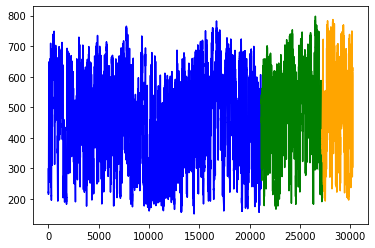

In [28]:
import matplotlib.pyplot as plt
plt.plot(df_train['emission_factor'], color = 'blue')
plt.plot(df_val['emission_factor'], color = 'green')
plt.plot(df_test['emission_factor'], color = 'orange')
plt.show()

In [29]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = df_train, val_df= df_val, test_df= df_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.features_train_df = train_df.drop(label_columns, axis = 1)
    self.target_train_df = pd.DataFrame(train_df[label_columns])
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(self.features_train_df.columns)}
    self.label_names = {name: i for i, name in
                           enumerate(self.target_train_df.columns)}
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width +shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size  - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features, target):
      inputs = features[:, self.input_slice, :]
      #inputs.drop(self.label_columns)
      labels = target[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.label_names[name]]for name in self.label_columns],axis=-1)
      # for name in self.label_columns ]
      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])

      return inputs, labels

def plot(self, plot_col, model=None, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.label_names[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, labels[n, :, plot_col_index],
             label='Target', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
WindowGenerator.plot = plot

In [30]:
shift = 0
input_width = 24
label_width = 24

window = WindowGenerator(input_width, label_width,shift, label_columns = ['emission_factor'])
window

Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s): ['emission_factor']

In [31]:
for name in window.label_columns:
    print(name)

emission_factor


In [32]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(df_train[:window.total_window_size]),
                           np.array(df_train[100:100+window.total_window_size]),
                           np.array(df_train[200:200+window.total_window_size])])

example_features = tf.stack([np.array(features_train[:window.total_window_size]),
                           np.array(features_train[100:100+window.total_window_size]),
                           np.array(features_train[200:200+window.total_window_size])])

example_co2 = tf.stack([np.array(co2_train[:window.total_window_size]),
                           np.array(co2_train[100:100+window.total_window_size]),
                           np.array(co2_train[200:200+window.total_window_size])])

example_co2 = tf.reshape(example_co2, shape = (3,24,1))
print(example_co2.shape)

# train shape
co2_copy = tf.reshape(co2_train, shape = (int(len(co2_train)/24),24,1))
features_copy = tf.reshape(features_train, shape = (int(len(co2_train)/24),24,32))

# validation shape
co2_copy_val = tf.reshape(co2_val, shape = (int(len(co2_val)/24),24,1))
features_copy_val = tf.reshape(features_val, shape = (int(len(co2_val)/24),24,32))

# test shape
co2_copy_test = tf.reshape(co2_test, shape = (int(len(co2_test)/24),24,1))
features_copy_test = tf.reshape(features_test, shape = (int(len(co2_test)/24),24,32))

inputs_train, labels_train = window.split_window(features_copy, co2_copy)
inputs_val, labels_val = window.split_window(features_copy_val, co2_copy_val)
inputs_test, labels_test = window.split_window(features_copy_test, co2_copy_test)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {inputs_train.shape}')
print(f'Labels shape: {labels_train.shape}')
print(f'Inputs vali shape: {inputs_val.shape}')
print(f'Labels vali shape: {labels_val.shape}')
print(f'Inputs test shape: {inputs_test.shape}')
print(f'Labels test shape: {labels_test.shape}')



(3, 24, 1)
All shapes are: (batch, time, features)
Window shape: (3, 24, 33)
Inputs shape: (882, 24, 32)
Labels shape: (882, 24, 1)
Inputs vali shape: (252, 24, 32)
Labels vali shape: (252, 24, 1)
Inputs test shape: (125, 24, 32)
Labels test shape: (125, 24, 1)


In [33]:
window.example = inputs_train, labels_train

In [34]:
window.label_names

{'emission_factor': 0}

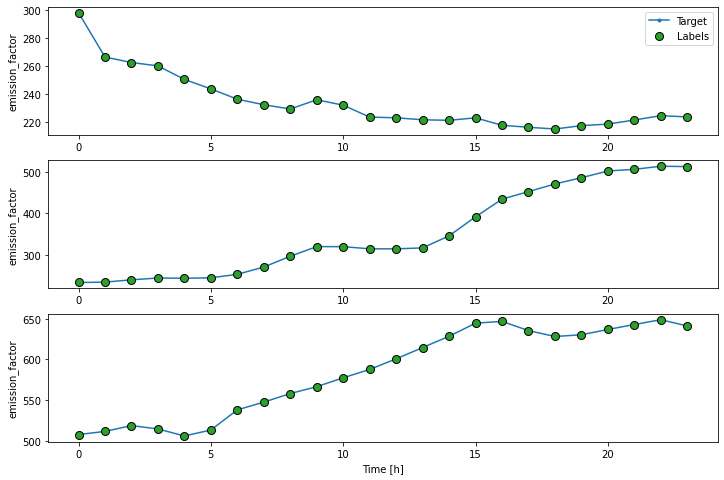

In [35]:
window.plot(plot_col = 'emission_factor')

In [36]:
def make_dataset(self, data):
  feauters = data.drop(self.label_columns, axis = 1)
  targets = data['emission_factor']
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      #features = dt
      data=features,
      targets=targets,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed = 42,
      batch_size=32,)

  ds = ds.map(self.split_window())

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)
WindowGenerator.train = train

In [163]:
learning_rate = 0.3
loss = 'mse'
optimizer = keras.optimizers.Adam(learning_rate)
#activation = 'relu'
dp_rate = 0.2
metrics=[tf.keras.metrics.RootMeanSquaredError()]

In [225]:
def LSTM_model(n_features, loss, optimizer, dp_rate, metrics):
    model = Sequential([
        LSTM(1028, return_sequences = True, input_shape = (24, n_features)),
        #LSTM(64, return_sequences = False,),
        #Dense(128, kernel_initializer='random_normal'),
        #Dropout(0.1),
        #Dense(128, kernel_initializer='random_normal', activation = 'relu'),
        #Dropout(0.1),
        Dense(2056, kernel_initializer='random_normal'),#, activation = 'relu'),
        Dropout(0.5),
        Dense(2056, kernel_initializer='random_normal'),#, activation = 'relu'),
        #Dropout(0.1),
        #Dense(128, kernel_initializer='random_normal', activation = 'relu'),
        Dense(1, kernel_initializer='random_normal') # random_normal
    ])
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

In [226]:
model_lstm = LSTM_model(n_features, loss, optimizer, dp_rate, metrics)

In [227]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [228]:
model_lstm.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 24, 1028)          4362832   
                                                                 
 dense_65 (Dense)            (None, 24, 2056)          2115624   
                                                                 
 dropout_25 (Dropout)        (None, 24, 2056)          0         
                                                                 
 dense_66 (Dense)            (None, 24, 2056)          4229192   
                                                                 
 dense_67 (Dense)            (None, 24, 1)             2057      
                                                                 
Total params: 10,709,705
Trainable params: 10,709,705
Non-trainable params: 0
_________________________________________________________________


In [229]:
callback = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    verbose = 0,
    patience = 15,
    mode = 'auto',
    restore_best_weights = True
)

In [240]:
from numpy.random import seed

In [241]:
seed(42)
tf.random.set_seed (42)

In [232]:
history = model_lstm.fit(inputs_train, labels_train, validation_data = (inputs_val, labels_val), batch_size = 256, epochs = 100, shuffle = False)

Epoch 1/100
4/4 [==============================] - 1s 128ms/step - loss: 2034.9387 - val_loss: 2302.7896
Epoch 2/100
4/4 [==============================] - 0s 111ms/step - loss: 2097.9951 - val_loss: 2415.3413
Epoch 3/100
4/4 [==============================] - 0s 115ms/step - loss: 2058.4324 - val_loss: 2565.3384
Epoch 4/100
4/4 [==============================] - 0s 111ms/step - loss: 2020.0004 - val_loss: 2461.4619
Epoch 5/100
4/4 [==============================] - 0s 112ms/step - loss: 2042.6317 - val_loss: 2363.4607
Epoch 6/100
4/4 [==============================] - 0s 115ms/step - loss: 2127.9292 - val_loss: 2443.9133
Epoch 7/100
4/4 [==============================] - 0s 112ms/step - loss: 2062.2449 - val_loss: 2654.9097
Epoch 8/100
4/4 [==============================] - 0s 114ms/step - loss: 2015.6775 - val_loss: 2684.2136
Epoch 9/100
4/4 [==============================] - 0s 113ms/step - loss: 1991.5781 - val_loss: 2433.8167
Epoch 10/100
4/4 [==============================] - 0s 

In [233]:
preds = model_lstm.predict(inputs_val)

8/8 [==============================] - 0s 11ms/step


In [234]:
preds.shape

(252, 24, 1)

In [235]:
preds = preds.reshape(252*24,1)

In [236]:
preds

array([[547.50757],
       [573.1878 ],
       [572.7472 ],
       ...,
       [288.0512 ],
       [290.16858],
       [288.0513 ]], dtype=float32)

In [237]:
co2_val

21168    506.521267
21169    504.916659
21170    513.695182
21171    523.851760
21172    540.933495
            ...    
27211    421.243254
27212    417.438725
27213    406.833526
27214    390.330244
27215    384.171132
Name: emission_factor, Length: 6048, dtype: float64

In [238]:
rep = fun.evaluation_without_uncertainty(preds, co2_val, 'LSTM')
print(rep)

MAE for LSTM: 37.96 g_CO2/kWh
MAPE for LSTM: 8.32 %
RMSE for LSTM: 48.06 g_CO2/kWh
R2 LSTM: 86.96000000000001 %


In [243]:
preds_df = pd.DataFrame(preds)
preds_df.index = co2_val.index
preds_df.head()

0
21168  547.507568
21169  573.187805
21170  572.747192
21171  585.244324
21172  592.127075

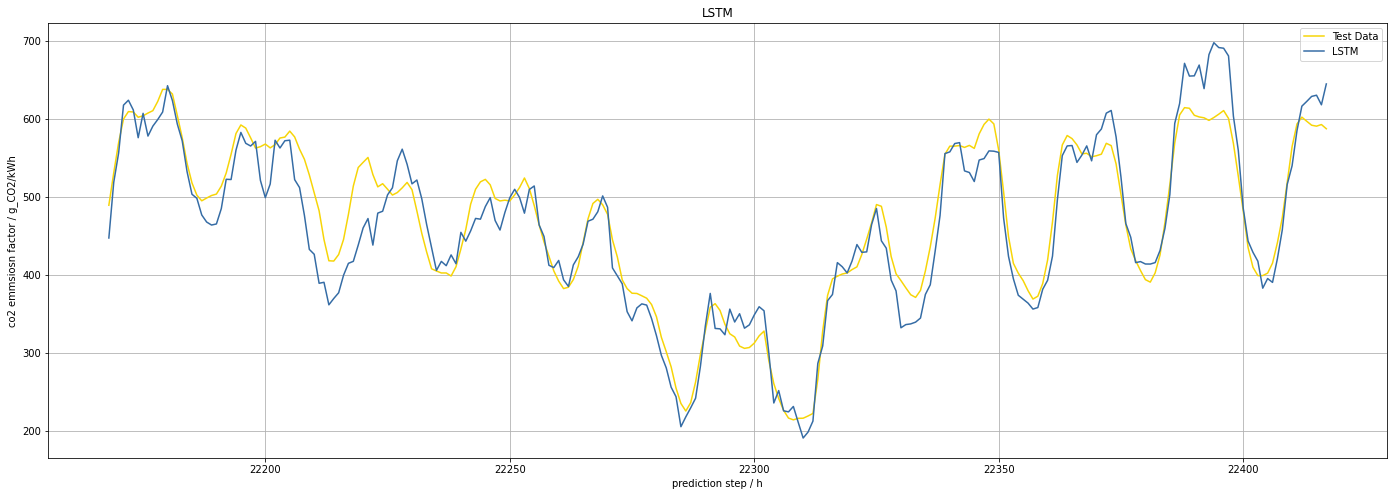

In [246]:
fun.plot_model(co2_val, preds_df, 1000, 1250, 'LSTM')

In [ ]:
MAE for LSTM: 38.08 g_CO2/kWh
MAPE for LSTM: 8.469999999999999 %
RMSE for LSTM: 47.64 g_CO2/kWh
R2 LSTM: 87.19 %


In [34]:
alpha_low = 0.025
alpha_high = 0.975
lower_val, mean_val, upper_val, report_val = dp.walk_forward_deep_learning(tscv_val, model_mlp, co2_train_val, features_train_val, co2_val, alpha_low, alpha_high,n_features, callback ,learning_rate = learning_rate, loss = loss, optimizer = optimizer,batch_size =32, epochs = 200, num_preds = 100, method = 'MLP', refit = True, validation = True)
print(report_val)

MAE for MLP: 29.08 g_CO2/kWh
MAPE for MLP: 6.569999999999999 %
RMSE for MLP: 36.75 g_CO2/kWh
Pinball for lower Quantile MLP: 3.03 g_CO2/kWh
Pinball for higher Quantile MLP: 5.38 g_CO2/kWh
Interval Score MLP: 94.8849 g_CO2/kWh
Real Values insisde PI MLP: 70.83 %
R2 MLP: 92.38 %
Adjusted R2 MLP: 92.34 %


In [56]:
print(report_val)#  adam, epoch = 32

MAE for MLP: 27.56 g_CO2/kWh
MAPE for MLP: 6.239999999999999 %
RMSE for MLP: 34.98 g_CO2/kWh
Pinball for lower Quantile MLP: 3.13 g_CO2/kWh
Pinball for higher Quantile MLP: 4.13 g_CO2/kWh
Interval Score MLP: 316.0856 g_CO2/kWh
Real Values insisde PI MLP: 73.56 %
R2 MLP: 93.08999999999999 %
Adjusted R2 MLP: 93.06 %


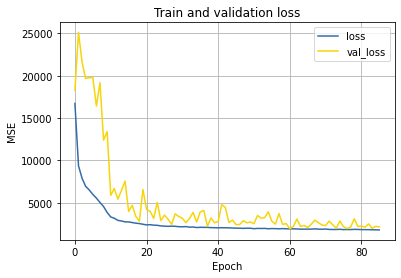

In [82]:
#dp.plot_loss(model_mlp_fit)

In [38]:
mlp_val_df = pd.DataFrame(mean_val)
#mlp_val_df.index = co2_val.index
mlp_val_df

0
0     556.990723
1     549.500549
2     556.375610
3     565.775879
4     571.694336
...          ...
6043  389.967865
6044  388.415314
6045  381.967072
6046  351.444763
6047  355.452850

[6048 rows x 1 columns]

In [39]:
co2_val.head()

21167    513.506720
21168    506.521267
21169    504.916659
21170    513.695182
21171    523.851760
Name: emission_factor, dtype: float64

In [40]:
lower_val

array([[502.5904068 ],
       [490.67334442],
       [505.53414307],
       ...,
       [355.15123672],
       [316.48031082],
       [324.50496063]])

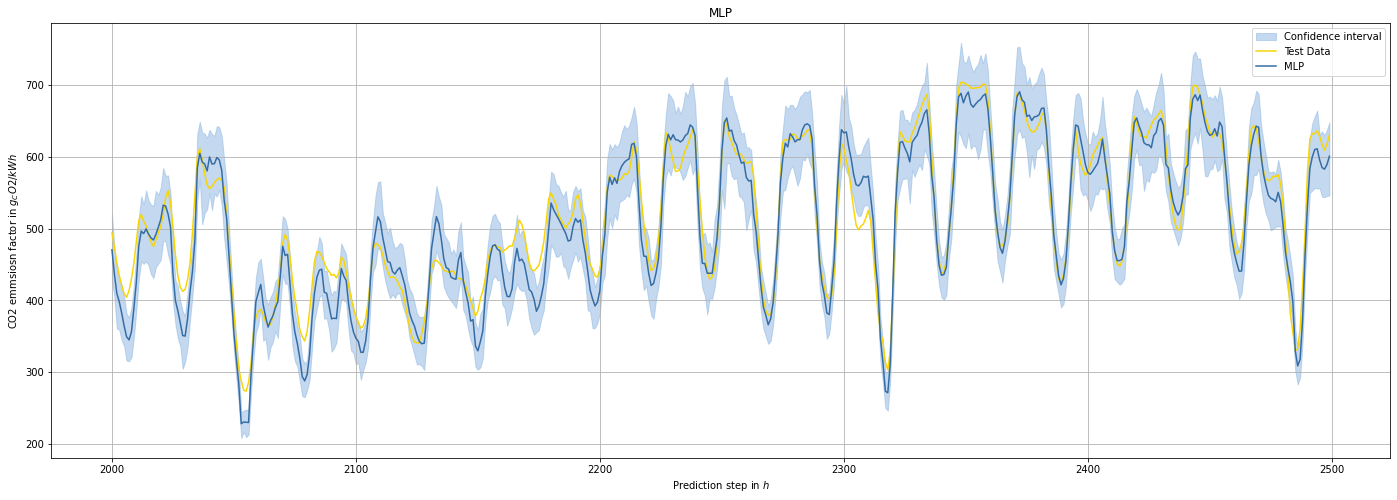

In [41]:
fun.plot_model_uncertainty(co2_val, mlp_val_df,lower_val[:,0],upper_val[:,0], slice_start = 2000, slice_end = 2500, method = 'MLP')

# walk forward testing

In [42]:
callback_test = keras.callbacks.EarlyStopping(
    monitor = 'loss',
    verbose = 0,
    patience = 10,
    mode = 'auto',
    restore_best_weights = True
)

In [46]:
learning_rate_test = 0.0005
loss = 'mse'
optimizer = keras.optimizers.Adam(learning_rate)

In [ ]:
alpha_low = 0.025
alpha_high = 0.975
lower_test, mean_test, upper_test, report_test = dp.walk_forward_deep_learning_cnn(tscv_test, model_mlp, co2, features, co2_test, alpha_low, alpha_high,n_features, callback_test ,learning_rate = learning_rate_test, loss = loss, optimizer = optimizer, batch_size =32, epochs = 5, num_preds = 100, method = 'CNN', refit = False, validation = False)
print(report_test)

Epoch 1/5
851/851 [==============================] - 7s 7ms/step - loss: 2131.2209
Epoch 2/5
851/851 [==============================] - 6s 7ms/step - loss: 2143.2554
Epoch 3/5
851/851 [==============================] - 6s 7ms/step - loss: 2198.9285
Epoch 4/5
851/851 [==============================] - 6s 7ms/step - loss: 2197.7495
Epoch 5/5
851/851 [==============================] - 6s 7ms/step - loss: 2100.8970


In [81]:
#print(mlp_test)

In [82]:
print(co2_test)

27215    384.171132
27216    394.529970
27217    395.021625
27218    380.836436
27219    372.334296
            ...    
30234    510.849600
30235    581.149058
30236    624.367735
30237    630.314545
30238    619.932072
Name: emission_factor, Length: 3024, dtype: float64


In [83]:
mlp_test_df = pd.DataFrame(mlp_test)
mlp_test_df.index = co2_test.index
mlp_test_df.head() 

0
27215  367.332428
27216  391.313477
27217  380.028687
27218  359.016388
27219  354.795288

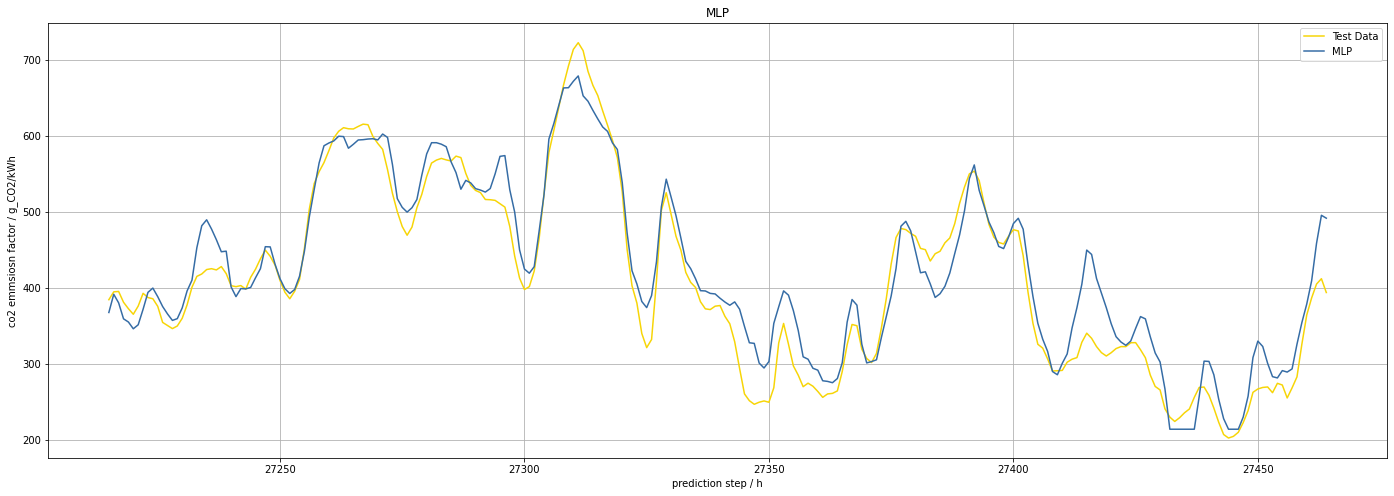

In [84]:
fun.plot_model(co2_test, mlp_test_df, slice_start = 0, slice_end = 250 , method = 'MLP')